In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm as normal
from scipy.stats import ttest_rel
import yfinance 
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
df = yfinance.download("AMZN", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [12]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,1906.489990,1954.510010,1870.000000,1953.949951,1953.949951,6761700
2020-03-03,1975.369995,1996.329956,1888.089966,1908.989990,1908.989990,7534500
2020-03-04,1946.569946,1978.000000,1922.000000,1975.829956,1975.829956,4772900
2020-03-05,1933.000000,1960.719971,1910.000000,1924.030029,1924.030029,4748200
2020-03-06,1875.000000,1910.869995,1869.500000,1901.089966,1901.089966,5273600


In [13]:
amazon.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,2878.268368,2916.571464,2836.458247,2877.467880,2877.467880,4.837083e+06
std,482.335284,480.748299,475.376145,475.356083,475.356083,1.833096e+06
min,1641.510010,1759.449951,1626.030029,1676.609985,1676.609985,1.451900e+06
25%,2462.500000,2486.500000,2443.354980,2471.724976,2471.724976,3.486100e+06
50%,3120.429932,3156.379883,3083.979980,3111.889893,3111.889893,4.394800e+06
75%,3209.344971,3247.234985,3165.714966,3205.604980,3205.604980,5.757700e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.203820e+07


## Price Movement

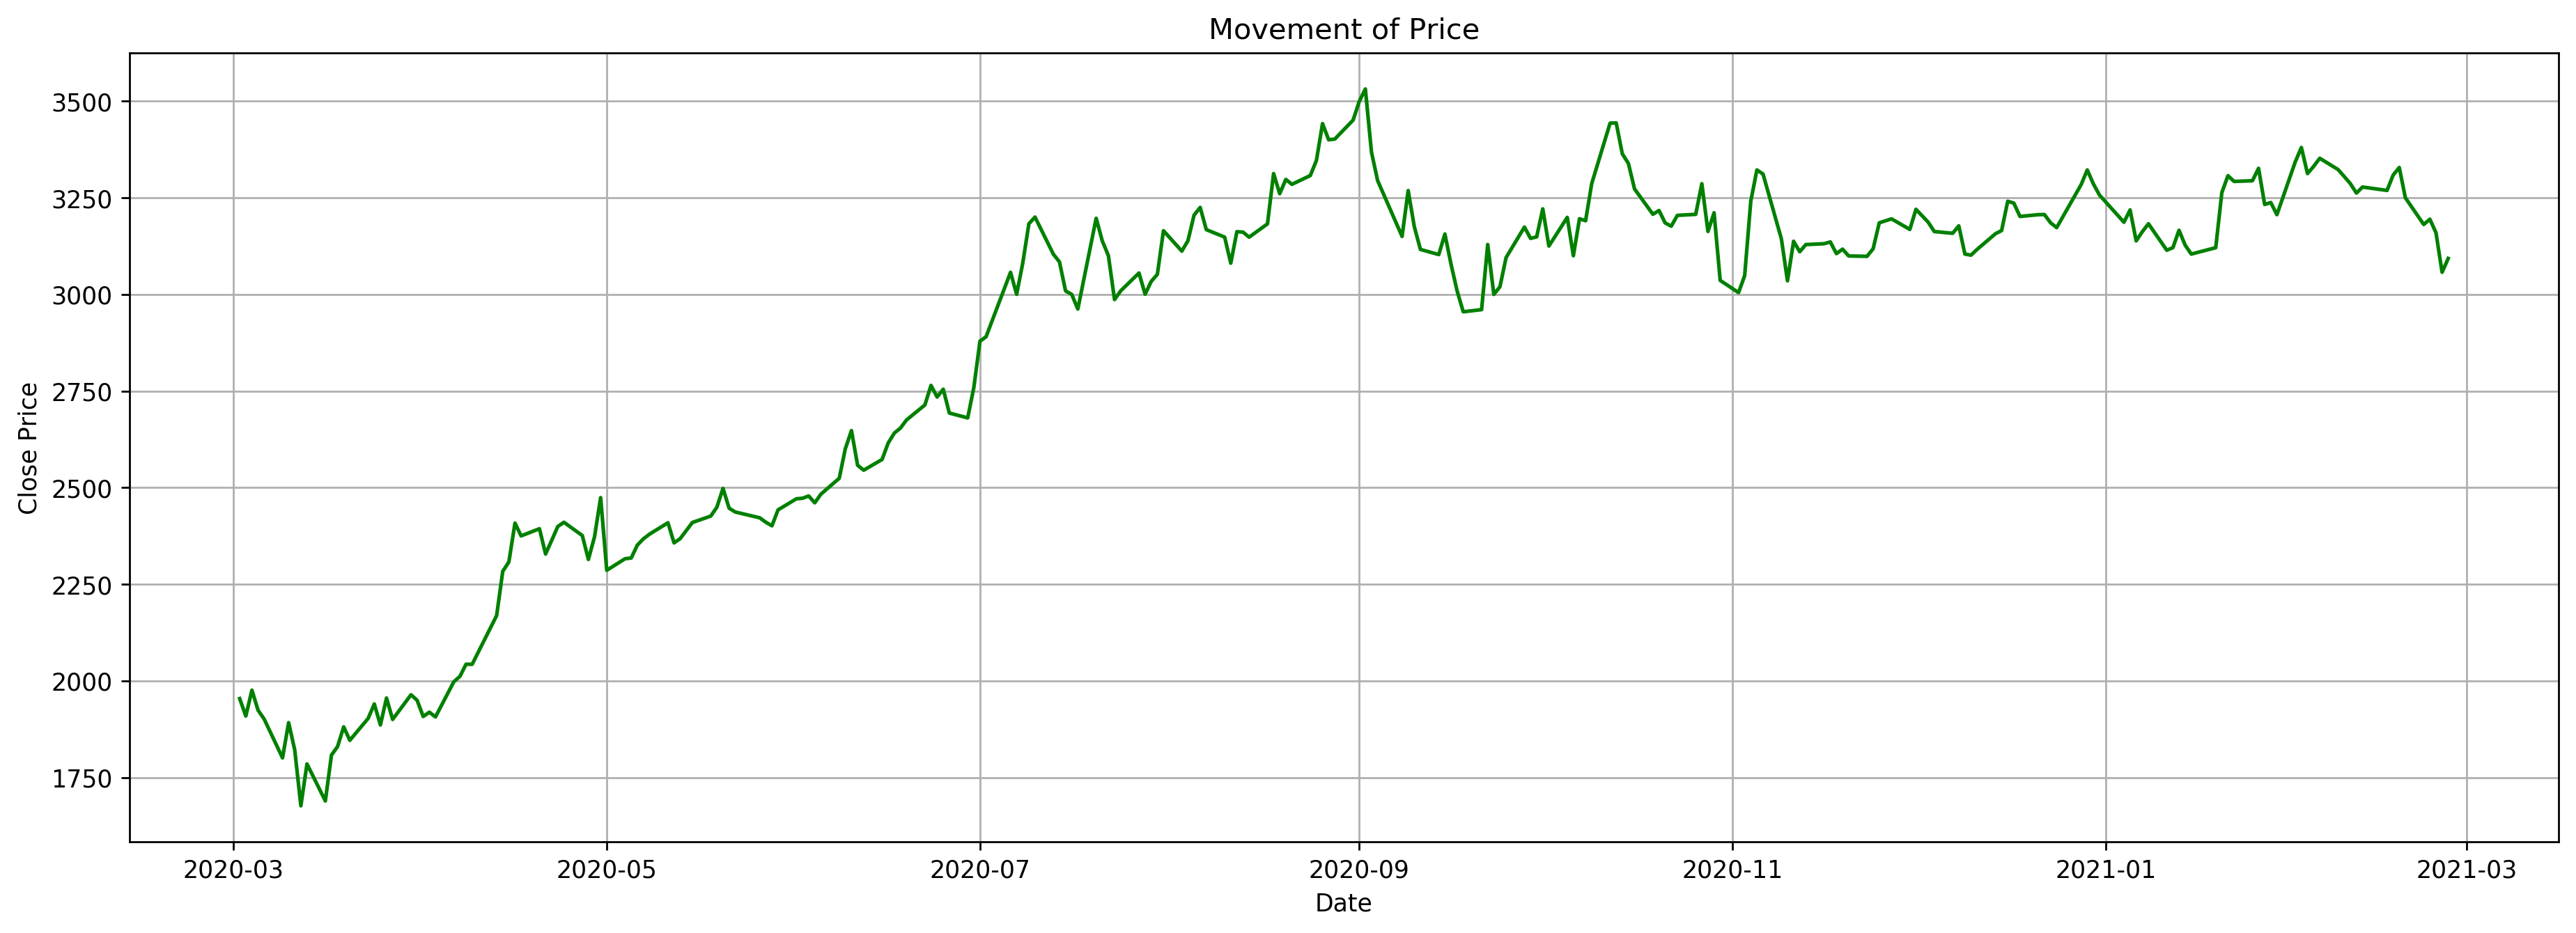

In [14]:
plt.figure(figsize=[18, 6], facecolor="w", dpi=250)
plt.grid()
plt.plot(amazon.index, amazon["Close"], color='green')
plt.xlabel("Date") 
plt.ylabel("Close Price")
plt.title("Movement of Price")
plt.show()

In [15]:
return_ = (amazon['Adj Close'] - amazon['Adj Close'].shift(1)) / amazon['Adj Close'].shift(1)
return_[1:]

Date
2020-03-03   -0.023010
2020-03-04    0.035013
2020-03-05   -0.026217
2020-03-06   -0.011923
2020-03-09   -0.052854
                ...   
2021-02-22   -0.021281
2021-02-23    0.004326
2021-02-24   -0.010947
2021-02-25   -0.032400
2021-02-26    0.011700
Name: Adj Close, Length: 250, dtype: float64

In [16]:
np.mean(return_)

0.0021244637601267537

Text(0.5, 1.0, 'Daily Return Spike')

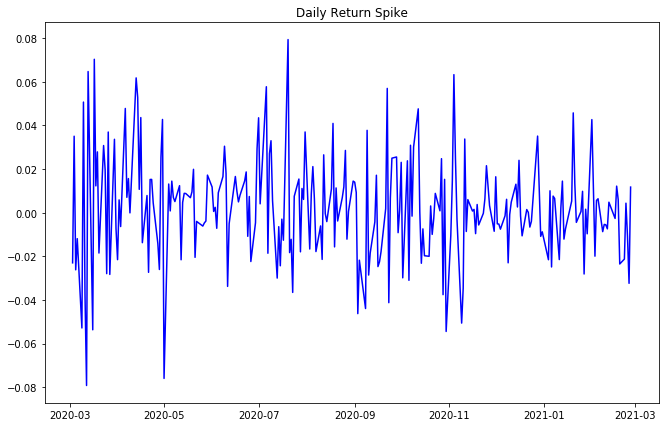

In [22]:
#Daily Return Chart
plt.figure(figsize=(11,7))
plt.plot(return_, color="blue")
plt.title("Daily Return Spike")

C:\Users\Porl-Timi\AppData\Roaming\Python\Python36\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Porl-Timi\AppData\Roaming\Python\Python36\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of Daily Return')

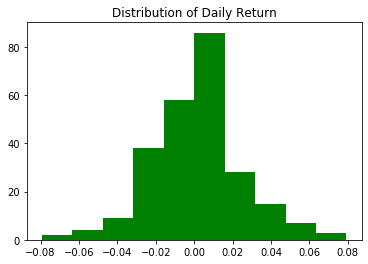

In [17]:
plt.hist(return_, bins=10, color="green")
plt.title("Distribution of Daily Return")

In [24]:
#12 months annualized volatility
anu_vol = round(np.std(return_) * np.sqrt(252), 4)
anu_vol

0.3799

###### 6 month volatility

In [25]:
#6 months annualized volatility
anu_six_vol = round(df['Adj Close'][:125].pct_change().apply(lambda x: np.log(1+x)).std() * np.sqrt(252), 4)
anu_six_vol

0.4207

## Black-Scholes Model

In [26]:
class BsmModel():    
    def __init__(self, S, E, t, r, sig):
        self.S = S
        self.E = E
        self.t = t
        self.r = r
        self.sig = sig
        self.d1 = (np.log(self.S/self.E) + (self.r + .5 * self.sig ** 2) * self.t) / (self.sig * np.sqrt(self.t))
        self.d2 = self.d1 - self.sig * np.sqrt(self.t)
             
    def put(self):      
        put_option = -self.S * normal.cdf(-self.d1) + (self.E / np.exp(self.r*(self.t)) * normal.cdf(-self.d2))        
        return put_option
    
    def delta(self):
        return np.round(-(np.exp(-self.r*self.t)* normal.pdf(self.d2))/(self.sig*self.S*np.sqrt(self.t)), 4)
    
    def speed(self):
        rat = (np.exp(-self.r*self.t)*normal.pdf(self.d2)/((self.sig**2) * (self.S**3)*np.sqrt(self.t))) * (-2*self.d1 + ((1 - self.d1*self.d2)/(self.sig*np.sqrt(self.t))))
        return rat
        
    def Theta(self):        
        lf = (self.r*np.exp(-self.r*self.t)*(1 - normal.cdf(self.d2))) - (np.exp(-self.r*self.t)*normal.pdf(self.d2)*((self.d1/(2*self.t))-((self.r)/(self.sig*np.sqrt(self.t))))) 
        return np.round(lf, 4)
        
    def gamma(self):
        gamma = (np.exp(-self.r * self.t) * self.d1 * normal.pdf(self.d2))/((self.sig ** 2) * (self.S**2)*(np.sqrt(self.t)))
        return np.round(gamma, 4)
    
    def vega(self):
        vega = (np.exp(-self.r*self.t)*normal.pdf(self.d2))*(self.d1/self.sig)
        return np.round(vega, 4)
    

### Binomial Model

In [27]:
class BinomialModel():
    def __init__(self, S, E, t, r, sig, N=3):
        self.S = S   
        self.E = E   
        self.t = t   
        self.r = r   
        self.vol = sig  
        self.N = N  
        ############################
    
    def time(self):
        return float(self.t) / self.N
    
    def up(self):
        return np.exp(self.vol * np.sqrt(self.time()))
    
    def down(self):
        return 1/self.up()
    
    def up_prob(self):
        a = np.exp(self.r * self.time())
        return (a - self.down())/(self.up() - self.down())
    
    def down_prob(self):
        return 1 - self.up_prob()
        
    def option(self):
        S0 = np.zeros((self.N+1, self.N+1))
        S0[0, 0] = self.S                                  ### S0 is the strike price
        z = 1
        for t in range(1, self.N + 1):
            for i in range(z):
                S0[i, t] = S0[i, t-1] * self.up()
                S0[i+1, t] = S0[i, t-1] * self.down()
            z+= 1 
            
        V = np.zeros_like(S0)   
        S_T = S0[:,-1]
        V[:,-1] = np.maximum(self.E - S_T, 0.0)

        for j in range(self.N-1, -1, -1):
            for i in range(j+1):
                V[i,j] = np.exp(-self.r*self.time()) * (self.up_prob() * V[i,j + 1] + self.down_prob() * V[i + 1,j + 1])
        return V[0,0]
        
#         if self.payoff == "call":
#             for j in range(self.N-1, -1, -1):
#                 for i in range(j+1):
#                     V[i,j] = np.maximum(S0[i,j] - self.E, np.exp(-self.r*self.time()) * (self.up_prob() * V[i,j + 1] + self.down_prob() * V[i + 1,j + 1]))
#             return  V[0,0]      
#         elif self.payoff == "put":
#             for j in range(N-1, -1, -1):
#                 for i in range(j+1):
#                     V[i,j] = np.maximum(self.E - S0[i,j], np.exp(-self.r*self.time()) * (self.up_prob() * V[i,j + 1] + self.down_prob() * V[i + 1,j + 1]))
#             return V[0,0]

## Model

In [28]:
amazon.loc["2020-11-17"]["Adj Close"]

3135.659912109375

In [29]:
price = amazon.loc["2020-11-17"]["Adj Close"]
strike = 3125
time = 5/360  ### days
sig = anu_vol
rate = .045

Black Scholes Model

In [30]:
model = BsmModel(S=price, E=strike, t=time, r=.045, sig=sig)
model.put()

49.809715142130926

Binomial Tree

In [31]:
model_ = BinomialModel(S=price, E=strike, t=time, r=.045, sig=sig)
model_.option()

54.423180236310586

## Greeks

### Delta

In [32]:
model.delta()

-0.0028

In [33]:
d = np.linspace(50,150,11)
delt = np.zeros_like(d)
for index, i in enumerate(d):
    delt[index] =  BsmModel(S=i, E=100, t=1, r=.04, sig=sig).delta()  

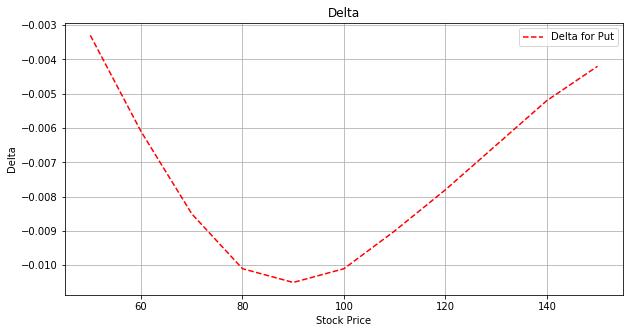

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(d, delt, '--', color="red")
plt.grid(b=True)
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

### Speed

In [35]:
model.speed()

1.6643376370872853e-08

In [ ]:
d = np.linspace(50,150,11)
speed = np.zeros_like(d)
for index, i in enumerate(d):
    speed[index] = BsmModel(S=i, E=100, t=1, r=.05, sig=sig).speed() 

In [38]:
s = np.linspace(70,150,11)
speed = np.zeros((len(s), 1))
for i in range(len(s)):
    speed[i] = BsmModel(S=s[i], E=100, t=1, r=.05, sig=sig).speed()    

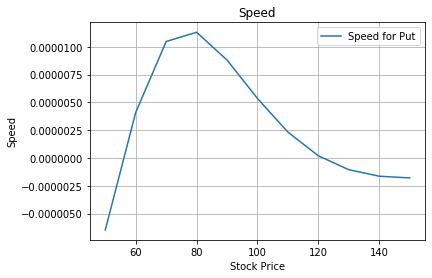

In [40]:
plt.figure()
plt.plot(d, speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put'])

### Theta

In [139]:
model.Theta()

-1.1886

In [140]:
Th = np.linspace(0.2, 1, 12)
_Th = np.zeros_like(Th)
for index, i in enumerate(Th):
    _Th[index] = BsmModel(S=100, E=100, t=i, r=.05, sig=sig).Theta()
    

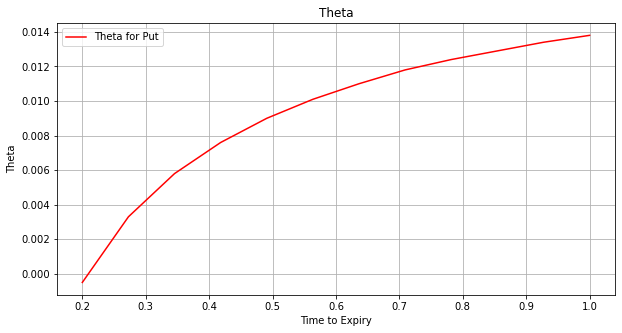

In [141]:
plt.figure(figsize=(10, 5))
plt.grid(b=True)
plt.plot(Th, _Th, '-', color="red")
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

### Gamma

In [142]:
model.gamma()

0.0

In [146]:
g = np.linspace(80,160,11)
gama = np.zeros_like(g)
for index ,i in enumerate(g):
    gama[index] = BsmModel(S=i, E=100, t=1, r=.05, sig=sig).gamma()   

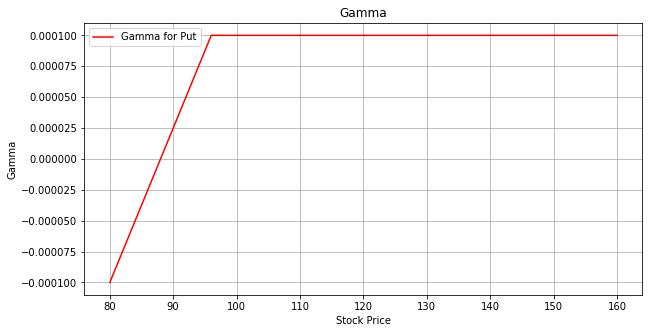

In [147]:
plt.figure(figsize=(10, 5))
plt.plot(g, gama, '-', color="red")
plt.grid(b=True)
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

### Vega

In [148]:
model.vega()

0.1177

In [151]:
v = np.linspace(0.1,0.4,13)
_v = np.zeros_like(v)
for index, i in enumerate(v):
    _v[index] = BsmModel(S=100, E=100, t=1, r=.05, sig=sig).vega()    

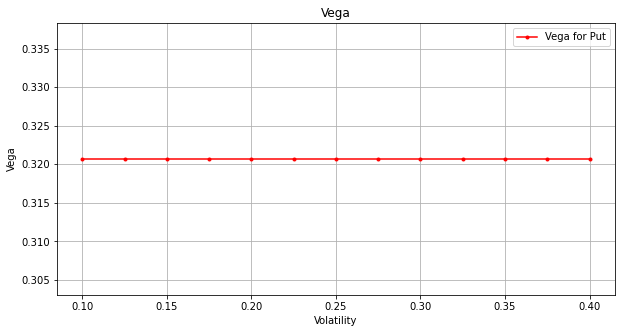

In [152]:
plt.figure(figsize=(10, 5))
plt.plot(v, _v, '.-', color="red")
plt.grid(b=True)
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Put'])

In [174]:
stock = np.linspace(3100, 3500, 24)
mat = np.linspace(0.1, 1, 24)
option = np. zeros_like(stock)
option2 = np. zeros_like(stock)
i=0
for price, tim in zip(stock, tte):    
    option[i] = BsmModel(S=price, E=strike, t=time, r=.045, sig=sig).put()
    option2[i] = BinomialModel(S=price, E=strike, t=time, r=.045, sig=sig).option()
    i+= 1

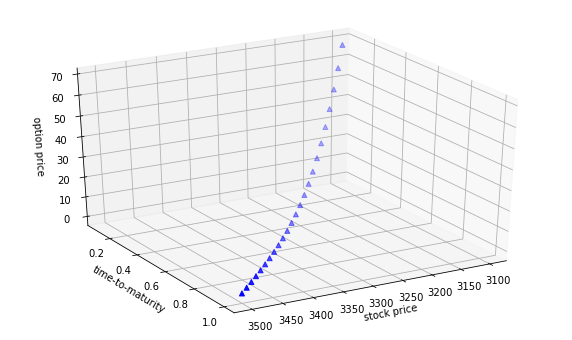

In [175]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)
ax.scatter(stock, mat, option, zdir='z', s=25, c='b', marker='^')
ax.set_xlabel('stock price')
ax.set_ylabel('time-to-maturity')
ax.set_zlabel('option price');

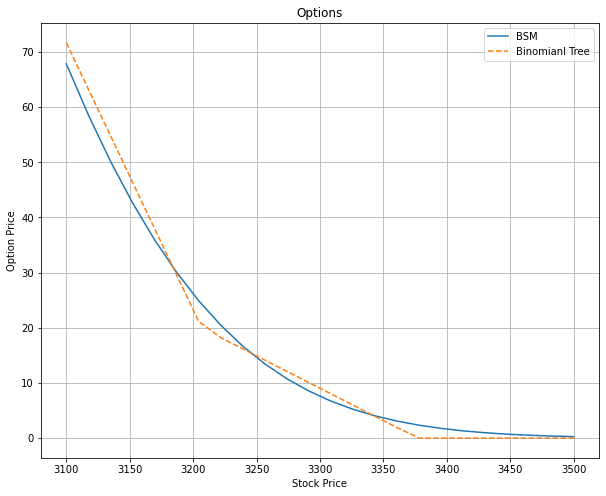

In [176]:
fig = plt.figure(figsize=[10, 8])

plt.grid(b=True)
plt.plot(stock, option, '-')
plt.plot(stock, option2, '--')


plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Options')
plt.legend(['BSM', "Binomianl Tree"])